In [18]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from sklearn.mixture import GaussianMixture


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
BATCH_SIZE=250
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=30,var1_u=60,CROP1=CROP,BATCH_SIZE=BATCH_SIZE,N_REPEAT_FRAME1=1)

In [4]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

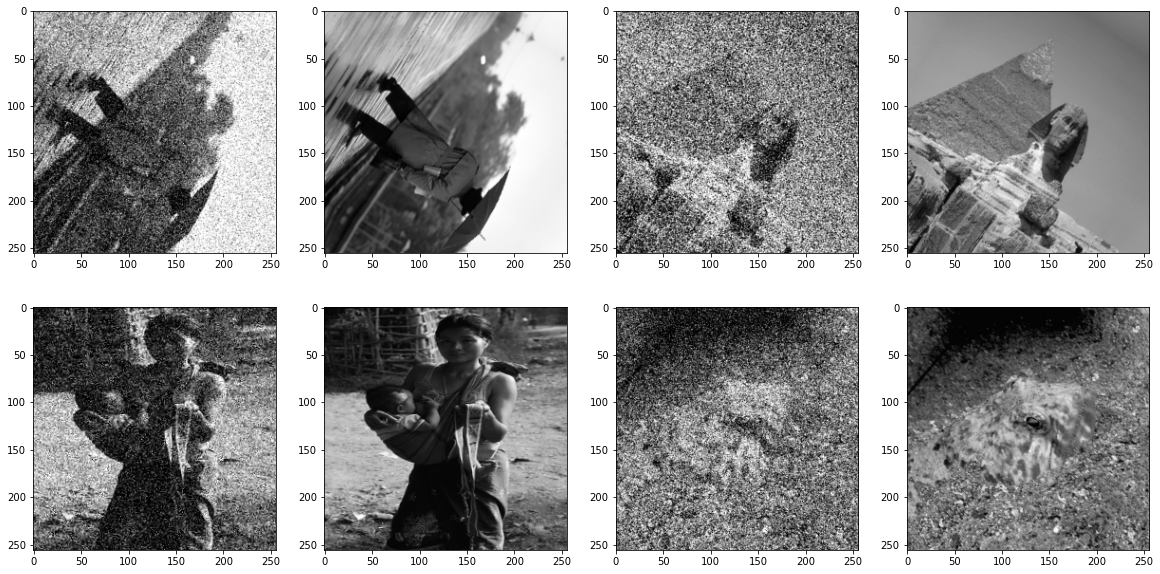

In [5]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        #axs[i,2*j].set_title(str(np.mean(xs[_])))
        
plt.show()

In [6]:
PSNR,TV = [],[]
xs, ys = next(gen_batch_train.as_numpy_iterator())

for l in tqdm(np.linspace(0.001,1,100)):

    psnr = []
    tv = []

    tv.append(tf.image.total_variation(tf.constant(ys)).numpy())
    img = np.array([anisodiff(image,niter=100,lambd=l) for image in xs])
    psnr.append(tf.image.psnr(ys,img,1)-tf.image.psnr(ys,xs,1))

    
    PSNR.append(np.copy(psnr))
    TV.append(np.copy(tv))
    
PSNR = np.array(PSNR)
TV = np.array(TV)

  0%|                                                   | 0/100 [00:00<?, ?it/s]2023-05-02 14:33:22.340859: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.26MiB (rounded to 65280000)requested by op StridedSlice
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-05-02 14:33:22.340893: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-05-02 14:33:22.340906: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 2, Chunks in use: 2. 512B allocated for chunks. 512B in use in bin. 9B client-requested in use in bin.
2023-05-02 14:33:22.340915: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.

ResourceExhaustedError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[250,255,256,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StridedSlice] name: strided_slice/

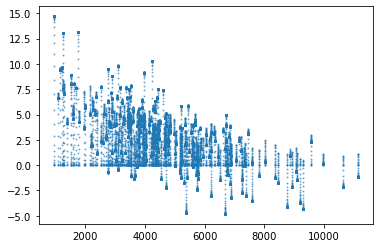

In [49]:
plt.scatter(TV.flatten(),PSNR.flatten(),s=1,alpha=0.5)

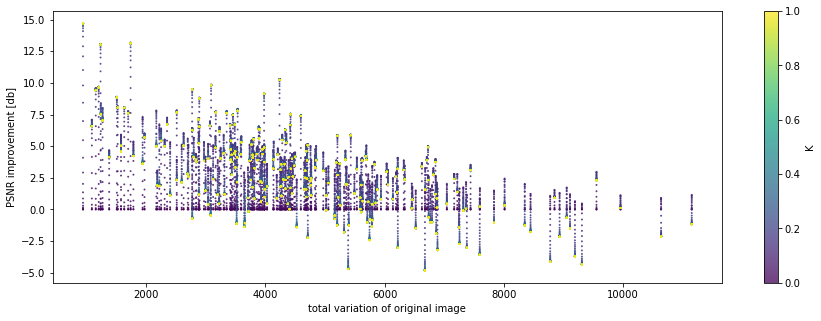

In [77]:
plt.figure(figsize=(15,5))
colors = cm.viridis(np.linspace(0,1,100))
c = np.multiply(np.expand_dims(np.arange(100),axis=-1),np.ones_like(np.squeeze(PSNR))).flatten()
c = np.asarray(c,dtype='int')
plt.scatter(TV.flatten(),PSNR.flatten(),s=1,alpha=0.75,color=colors[c])
plt.colorbar(label='K')
plt.xlabel('total variation of original image')
plt.ylabel('PSNR improvement [db]')
plt.show()

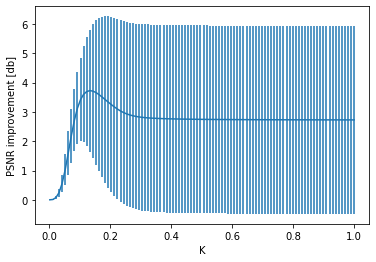

In [57]:
plt.errorbar(np.linspace(0.001,1,100),np.mean(np.squeeze(PSNR),axis=-1),np.std(np.squeeze(PSNR),axis=-1))
plt.xlabel('K')
plt.ylabel('PSNR improvement [db]')
plt.show()

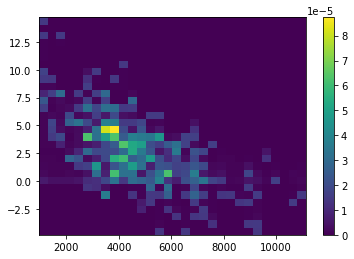

In [65]:
plt.hist2d(TV.flatten(),PSNR.flatten(),bins=30,density=True)
plt.colorbar()
plt.show()

In [66]:
dx,dy = tf.image.image_gradients(tf.constant(ys))
grad = np.sqrt(dx**2+dy**2)

In [70]:
q = []

for l in tqdm(np.linspace(0.001,1,100)):
    q.append(np.sum(grad.flatten()<l)/len(grad.flatten()))

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 37.78it/s]


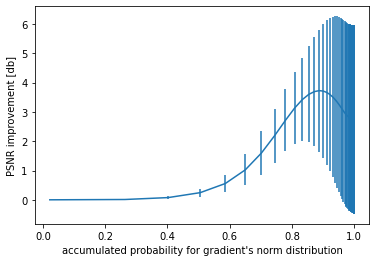

In [79]:
plt.errorbar(q,np.mean(np.squeeze(PSNR),axis=-1),np.std(np.squeeze(PSNR),axis=-1))
plt.xlabel("accumulated probability for gradient's norm distribution")
plt.ylabel('PSNR improvement [db]')
plt.show()

# Perona Malik 1d

In [665]:
def diffusivity(x,k=1):
    return 1/(1+(x/k)**2)
    #return np.exp(-(x/k)**2)

In [666]:
def pm_it (c,h=4*np.pi/1000,k=1,gamma=0.1):
    x = np.copy(c)
    g = np.gradient(x/h)
    dif = diffusivity(g,k)
    g = np.multiply(g,dif)
    g = np.gradient(g)
    x = x+gamma*g
    
    return x

def pm(c,h=4*np.pi/1000,k=1,gamma=0.01,niter = 1):
    for i in range(niter):
        c = pm_it(c,h=h,k=k,gamma=gamma)
        c[0] = 0
        c[1] = 0
        c[-1] = 0
        c[-2] = 0
        
    return c

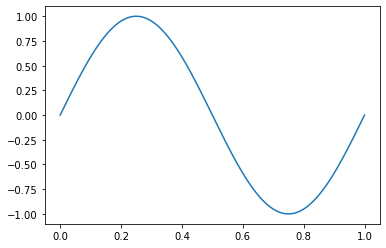

In [599]:
w = 2*np.pi
t = np.linspace(0,1,1000)
f = np.sin(w*t)
plt.plot(t,f)

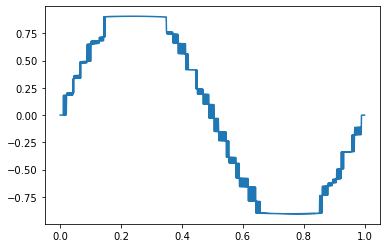

In [600]:
gamma = 0.01
k = 0.5
h = w/len(f)

plt.plot(t,pm(f,niter=int(100/gamma),k=k,gamma=gamma,h=h))


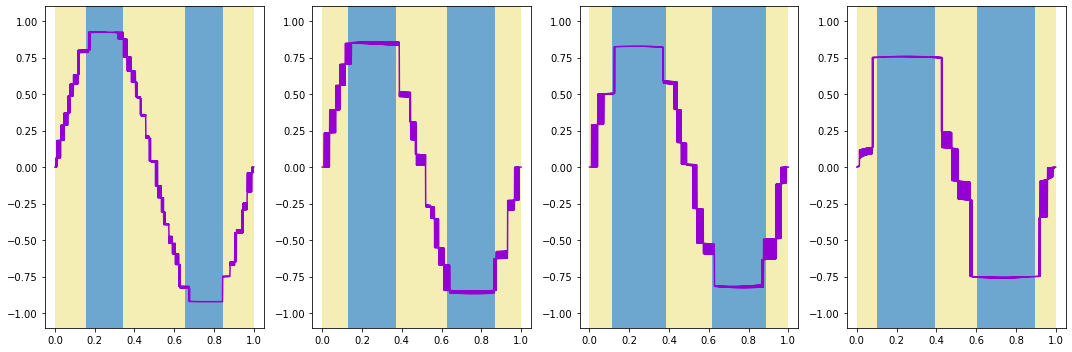

In [694]:
K = [0.2,0.4,0.60,0.8]

fig,axs = plt.subplots(ncols=len(K),figsize=(15,5))

for k0 in range(len(K)):
    gamma = 0.01
    h = w/len(f)
    k = K[k0]

    s = np.linspace(0,2,5000)
    s0 = np.sqrt(k/np.sqrt(3))
    a = diffusivity(s,k)
    b = a+2*(s)*np.gradient(a/h)

    root = s[np.argmin(np.abs(a-s0-2*(s)*np.gradient(a/h)))]

    axs[k0].plot(t,pm(f,niter=int(500/gamma),k=k,gamma=gamma,h=h),color='darkviolet')

    change = (np.gradient(f/h)**2 > root)
    jumps = np.where(change[1:]!=change[:-1])[0]
    jumps = np.concatenate((jumps,[len(f)-1]))

    if change[j]:            
        axs[k0].axvspan(0,t[jumps[0]],facecolor='khaki',alpha=0.65)
    else:
        axs[k0].axvspan(0,t[jumps[0]],facecolor='tab:blue',alpha=0.65)

    for i,j in enumerate(jumps):
        if change[j]:            
            axs[k0].axvspan(t[jumps[max(0,i-1)]],t[j],facecolor='khaki',alpha=0.65)
        else:
            axs[k0].axvspan(t[jumps[max(0,i-1)]],t[j],facecolor='tab:blue',alpha=0.65)
            
    axs[k0].set_ylim(-1.1,1.1)
            
plt.tight_layout()
plt.show()

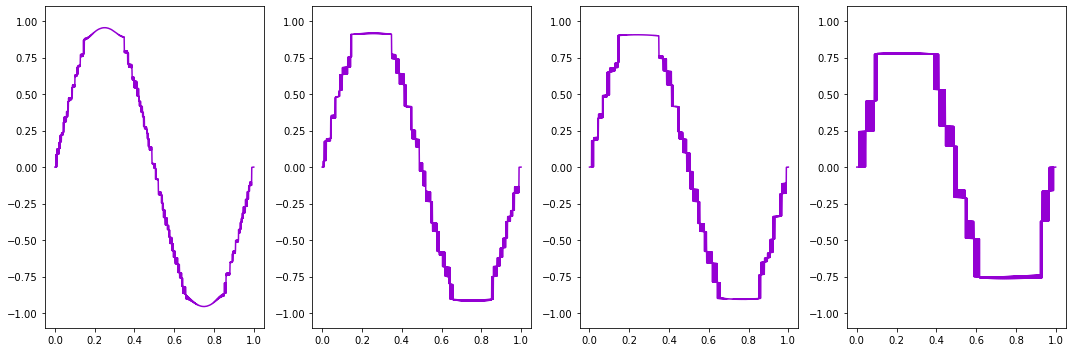

In [695]:
K = [10,50,100,1000]

fig,axs = plt.subplots(ncols=len(K),figsize=(15,5))

for k0 in range(len(K)):
    gamma = 0.01
    h = w/len(f)
    k = 0.5

    s = np.linspace(0,2,5000)
    s0 = np.sqrt(k/np.sqrt(3))
    a = diffusivity(s,k)
    b = a+2*(s)*np.gradient(a/h)

    root = s[np.argmin(np.abs(a-s0-2*(s)*np.gradient(a/h)))]

    axs[k0].plot(t,pm(f,niter=int(K[k0]/gamma),k=k,gamma=gamma,h=h),color='darkviolet')

    
            
    axs[k0].set_ylim(-1.1,1.1)
            
plt.tight_layout()
plt.show()

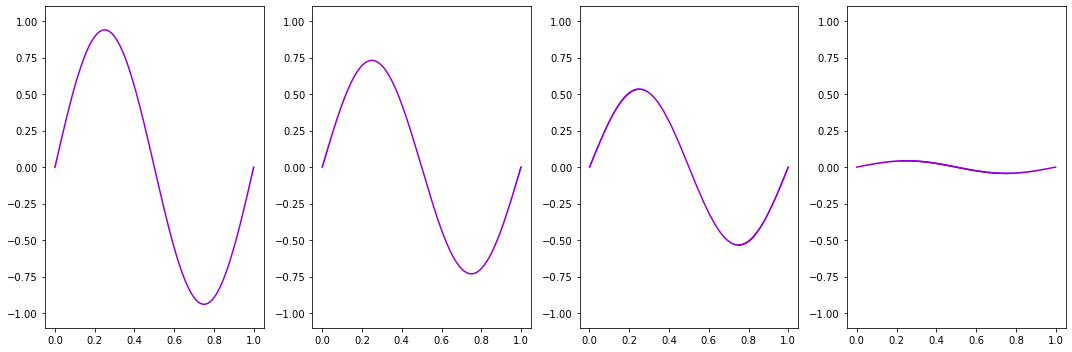

In [703]:
K = [10,50,100,500]

fig,axs = plt.subplots(ncols=len(K),figsize=(15,5))

for k0 in range(len(K)):
    gamma = 0.01
    h = w/len(f)
    k = 10

    s = np.linspace(0,2,5000)
    s0 = np.sqrt(k/np.sqrt(3))
    a = diffusivity(s,k)
    b = a+2*(s)*np.gradient(a/h)

    root = s[np.argmin(np.abs(a-s0-2*(s)*np.gradient(a/h)))]

    axs[k0].plot(t,pm(f,niter=int(K[k0]/gamma),k=k,gamma=gamma,h=h),color='darkviolet')

    
            
    axs[k0].set_ylim(-1.1,1.1)
            
plt.tight_layout()
plt.show()

# Computing optimal K

In [24]:
var_d=10
var_u=var_d

test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

chosen_set = train
chosen_image = np.random.choice(chosen_set)
var = np.random.uniform(var_d,var_u)
batch = open_frame(chosen_image,var,CROP)

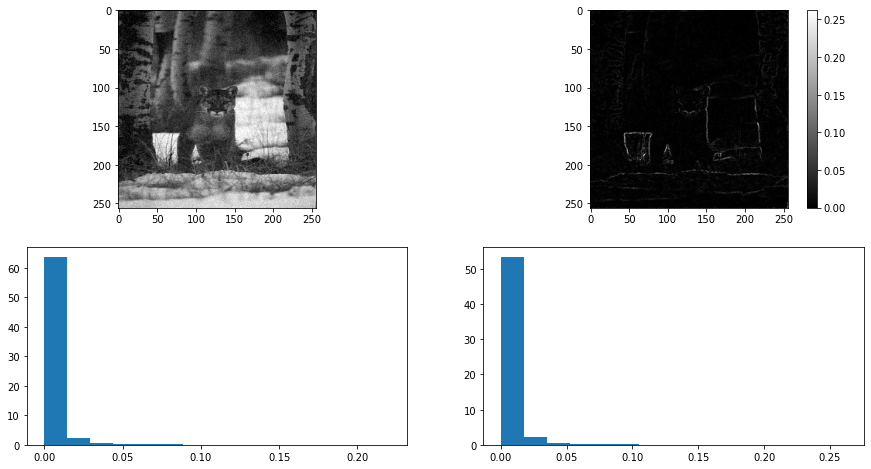

In [25]:
or_im,im = batch

g = np.gradient(im)
g = g[0]**2+g[1]**2

f = np.gradient(or_im)
f = f[0]**2+f[1]**2


plt.figure(figsize=(15,8))
plt.subplot(221)
plt.imshow(im,cmap='gray')
plt.subplot(222)
plt.imshow(g,cmap='gray')
plt.colorbar()
plt.subplot(223)
plt.hist(f.flatten(),bins=15,density=True)
plt.subplot(224)
plt.hist(g.flatten(),bins=15,density=True)
plt.show()

In [26]:
t = np.linspace(0,1,10000)

gradients = np.expand_dims(g.flatten(),axis=-1)
gm = GaussianMixture(n_components=2, random_state=0).fit(gradients)
predictions = gm.predict(gradients)

ty = 0
mean = gm.means_[ty]
std = np.std(gradients[predictions==ty])
normal_0 = np.exp(-(((t-mean)/std)**2)/2)/(std*np.sqrt(2*np.pi))

ty = 1
mean = gm.means_[ty]
std = np.std(gradients[predictions==ty])
normal_1 = np.exp(-(((t-mean)/std)**2)/2)/(std*np.sqrt(2*np.pi))

lim = np.argmin(np.abs(t-0.5*np.amax(g)))
gaussian_K = t[np.argmin(np.abs(normal_0 - normal_1)[:lim])]

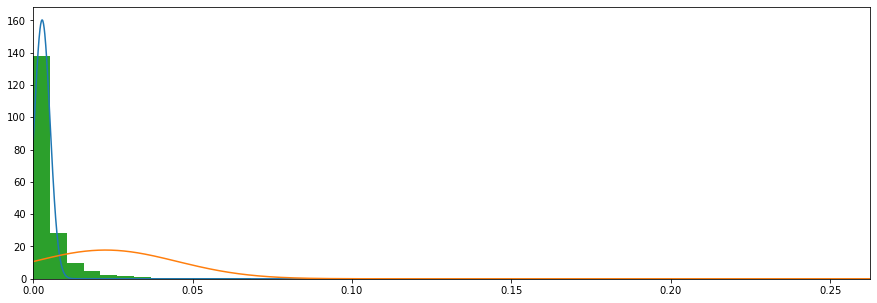

In [27]:
plt.figure(figsize=(15,5))
plt.plot(t,normal_0)
plt.plot(t,normal_1)
plt.hist(g.flatten(),bins=50,density=True)
plt.xlim(0,1*np.amax(g))
plt.show()

In [29]:
psnr,ssim = [],[]

ssim_im = np.expand_dims(or_im,axis=-1)
ssim_im = np.asarray(ssim_im,dtype=or_im.dtype)

for k in tqdm(np.linspace(0.01,1,100)):
    filtered = anisodiff(im,niter = 5,lambd = k)
    psnr.append(tf.image.psnr(np.array([np.squeeze(or_im)]),np.array([filtered]),1).numpy())
    filtered_ssim = np.asarray(np.expand_dims(filtered,axis=-1),dtype='float32')
    ssim.append(tf.image.ssim(filtered_ssim,ssim_im,1).numpy())

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 75.64it/s]


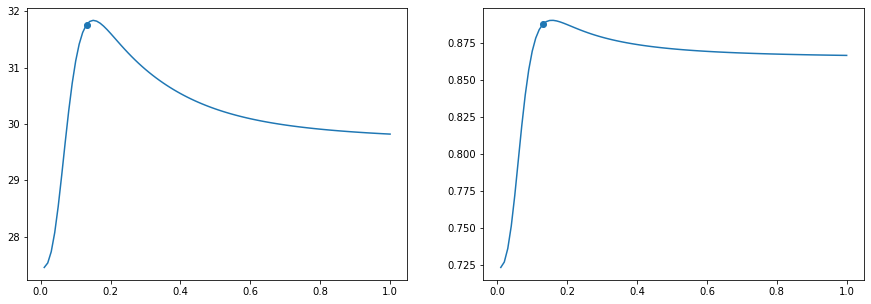

In [30]:
filtered = anisodiff(im,niter = 5,lambd = gaussian_K)
filtered_ssim = np.asarray(np.expand_dims(filtered,axis=-1),dtype='float32')
psnr_gaussian = tf.image.psnr(np.array([np.squeeze(or_im)]),np.array([filtered]),1).numpy()
ssim_gaussian = tf.image.ssim(filtered_ssim,ssim_im,1).numpy()

                           
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(np.linspace(0.01,1,100),psnr)
plt.scatter(gaussian_K,psnr_gaussian)
plt.subplot(122)
plt.plot(np.linspace(0.01,1,100),ssim)
plt.scatter(gaussian_K,ssim_gaussian)

In [74]:
var = 10
test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

G_NOISY_K,G_ORIGINAL_K = [],[]
PSNR_K,SSIM_K = [],[]

for chosen_image in tqdm(train):
    batch = open_frame(chosen_image,var,CROP)
    
    or_im,im = batch

    g = np.gradient(im)
    g = g[0]**2+g[1]**2

    f = np.gradient(or_im)
    f = f[0]**2+f[1]**2
    
    t = np.linspace(0.05,1,10000)
    gradients = np.expand_dims(g.flatten(),axis=-1)
    gm = GaussianMixture(n_components=2, random_state=0).fit(gradients)
    predictions = gm.predict(gradients)

    ty = 0
    mean = gm.means_[ty]
    std = np.std(gradients[predictions==ty])
    normal_0 = np.exp(-(((t-mean)/std)**2)/2)/(std*np.sqrt(2*np.pi))

    ty = 1
    mean = gm.means_[ty]
    std = np.std(gradients[predictions==ty])
    normal_1 = np.exp(-(((t-mean)/std)**2)/2)/(std*np.sqrt(2*np.pi))
    
    lim = np.argmin(np.abs(t-min(0.35,0.5*np.amax(g))))
    gaussian_noisy_K = t[np.argmin(np.abs(normal_0 - normal_1)[:lim+1])]
    filtered_gaussian = anisodiff(im,niter = 5,lambd = gaussian_noisy_K)
    filtered_ssim = np.asarray(np.expand_dims(filtered_gaussian,axis=-1),dtype='float32')
    psnr_gaussian = tf.image.psnr(np.array([np.squeeze(or_im)]),np.array([filtered_gaussian]),1).numpy()
    ssim_im = np.expand_dims(or_im,axis=-1)
    ssim_im = np.asarray(ssim_im,dtype=or_im.dtype)
    ssim_gaussian = tf.image.ssim(filtered_ssim,ssim_im,1).numpy()
    
    G_NOISY_K.append(psnr_gaussian)
    G_ORIGINAL_K.append(ssim_gaussian)
    #####################
    '''
    gradients = np.expand_dims(f.flatten(),axis=-1)
    gm = GaussianMixture(n_components=2, random_state=0).fit(gradients)
    predictions = gm.predict(gradients)

    ty = 0
    mean = gm.means_[ty]
    std = np.std(gradients[predictions==ty])
    normal_0 = np.exp(-(((t-mean)/std)**2)/2)/(std*np.sqrt(2*np.pi))

    ty = 1
    mean = gm.means_[ty]
    std = np.std(gradients[predictions==ty])
    normal_1 = np.exp(-(((t-mean)/std)**2)/2)/(std*np.sqrt(2*np.pi))
    
    lim = np.argmin(np.abs(t-min(0.35,0.5*np.amax(f))))
    gaussian_original_K = t[np.argmin(np.abs(normal_0 - normal_1)[:lim+1])]
    '''
    ######################33
    psnr,ssim = [],[]

    ssim_im = np.expand_dims(or_im,axis=-1)
    ssim_im = np.asarray(ssim_im,dtype=or_im.dtype)

    for k in np.linspace(0.01,1,100):
        filtered = anisodiff(im,niter = 5,lambd = k)
        psnr.append(tf.image.psnr(np.array([np.squeeze(or_im)]),np.array([filtered]),1).numpy())
        filtered_ssim = np.asarray(np.expand_dims(filtered,axis=-1),dtype='float32')
        ssim.append(tf.image.ssim(filtered_ssim,ssim_im,1).numpy())
        
    
    PSNR_K.append(np.amax(psnr))
    SSIM_K.append(np.amax(ssim))

100%|█████████████████████████████████████████| 300/300 [07:50<00:00,  1.57s/it]


In [71]:
G_NOISY_K = np.array(G_NOISY_K)
G_ORIGINAL_K = np.array(G_ORIGINAL_K)
PSNR_K = np.array(PSNR_K)
SSIM_K = np.array(SSIM_K)

print(np.mean(np.abs(PSNR_K-G_NOISY_K)/PSNR_K),np.mean(np.abs(PSNR_K-G_NOISY_K)))
print(np.mean(np.abs(SSIM_K-G_ORIGINAL_K)/SSIM_K),np.mean(np.abs(SSIM_K-G_ORIGINAL_K)))

0.08039447 2.5044205
0.119962305 0.10071391


In [75]:
var = 20
test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

G_NOISY_K,G_ORIGINAL_K = [],[]
PSNR_K,SSIM_K = [],[]

for chosen_image in tqdm(train):
    batch = open_frame(chosen_image,var,CROP)
    
    or_im,im = batch

    g = np.gradient(im)
    g = g[0]**2+g[1]**2

    f = np.gradient(or_im)
    f = f[0]**2+f[1]**2
    
    t = np.linspace(0.05,1,10000)
    gradients = np.expand_dims(g.flatten(),axis=-1)
    gm = GaussianMixture(n_components=2, random_state=0).fit(gradients)
    predictions = gm.predict(gradients)

    ty = 0
    mean = gm.means_[ty]
    std = np.std(gradients[predictions==ty])
    normal_0 = np.exp(-(((t-mean)/std)**2)/2)/(std*np.sqrt(2*np.pi))

    ty = 1
    mean = gm.means_[ty]
    std = np.std(gradients[predictions==ty])
    normal_1 = np.exp(-(((t-mean)/std)**2)/2)/(std*np.sqrt(2*np.pi))
    
    lim = np.argmin(np.abs(t-min(0.35,0.5*np.amax(g))))
    gaussian_noisy_K = t[np.argmin(np.abs(normal_0 - normal_1)[:lim+1])]
    filtered_gaussian = anisodiff(im,niter = 5,lambd = gaussian_noisy_K)
    filtered_ssim = np.asarray(np.expand_dims(filtered_gaussian,axis=-1),dtype='float32')
    psnr_gaussian = tf.image.psnr(np.array([np.squeeze(or_im)]),np.array([filtered_gaussian]),1).numpy()
    ssim_im = np.expand_dims(or_im,axis=-1)
    ssim_im = np.asarray(ssim_im,dtype=or_im.dtype)
    ssim_gaussian = tf.image.ssim(filtered_ssim,ssim_im,1).numpy()
    
    G_NOISY_K.append(psnr_gaussian)
    G_ORIGINAL_K.append(ssim_gaussian)

    
    
    psnr,ssim = [],[]

    ssim_im = np.expand_dims(or_im,axis=-1)
    ssim_im = np.asarray(ssim_im,dtype=or_im.dtype)

    for k in np.linspace(0.01,1,100):
        filtered = anisodiff(im,niter = 5,lambd = k)
        psnr.append(tf.image.psnr(np.array([np.squeeze(or_im)]),np.array([filtered]),1).numpy())
        filtered_ssim = np.asarray(np.expand_dims(filtered,axis=-1),dtype='float32')
        ssim.append(tf.image.ssim(filtered_ssim,ssim_im,1).numpy())
        
    
    PSNR_K.append(np.amax(psnr))
    SSIM_K.append(np.amax(ssim))
    
G_NOISY_K = np.array(G_NOISY_K)
G_ORIGINAL_K = np.array(G_ORIGINAL_K)
PSNR_K = np.array(PSNR_K)
SSIM_K = np.array(SSIM_K)

print(np.mean(np.abs(PSNR_K-G_NOISY_K)/PSNR_K),np.mean(np.abs(PSNR_K-G_NOISY_K)))
print(np.mean(np.abs(SSIM_K-G_ORIGINAL_K)/SSIM_K),np.mean(np.abs(SSIM_K-G_ORIGINAL_K)))

100%|█████████████████████████████████████████| 300/300 [07:44<00:00,  1.55s/it]

0.05593764 1.5379581
0.111956865 0.07659099


In [76]:
var = 30
test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

G_NOISY_K,G_ORIGINAL_K = [],[]
PSNR_K,SSIM_K = [],[]

for chosen_image in tqdm(train):
    batch = open_frame(chosen_image,var,CROP)
    
    or_im,im = batch

    g = np.gradient(im)
    g = g[0]**2+g[1]**2

    f = np.gradient(or_im)
    f = f[0]**2+f[1]**2
    
    t = np.linspace(0.05,1,10000)
    gradients = np.expand_dims(g.flatten(),axis=-1)
    gm = GaussianMixture(n_components=2, random_state=0).fit(gradients)
    predictions = gm.predict(gradients)

    ty = 0
    mean = gm.means_[ty]
    std = np.std(gradients[predictions==ty])
    normal_0 = np.exp(-(((t-mean)/std)**2)/2)/(std*np.sqrt(2*np.pi))

    ty = 1
    mean = gm.means_[ty]
    std = np.std(gradients[predictions==ty])
    normal_1 = np.exp(-(((t-mean)/std)**2)/2)/(std*np.sqrt(2*np.pi))
    
    lim = np.argmin(np.abs(t-min(0.35,0.5*np.amax(g))))
    gaussian_noisy_K = t[np.argmin(np.abs(normal_0 - normal_1)[:lim+1])]
    filtered_gaussian = anisodiff(im,niter = 5,lambd = gaussian_noisy_K)
    filtered_ssim = np.asarray(np.expand_dims(filtered_gaussian,axis=-1),dtype='float32')
    psnr_gaussian = tf.image.psnr(np.array([np.squeeze(or_im)]),np.array([filtered_gaussian]),1).numpy()
    ssim_im = np.expand_dims(or_im,axis=-1)
    ssim_im = np.asarray(ssim_im,dtype=or_im.dtype)
    ssim_gaussian = tf.image.ssim(filtered_ssim,ssim_im,1).numpy()
    
    G_NOISY_K.append(psnr_gaussian)
    G_ORIGINAL_K.append(ssim_gaussian)

    
    
    psnr,ssim = [],[]

    ssim_im = np.expand_dims(or_im,axis=-1)
    ssim_im = np.asarray(ssim_im,dtype=or_im.dtype)

    for k in np.linspace(0.01,1,100):
        filtered = anisodiff(im,niter = 5,lambd = k)
        psnr.append(tf.image.psnr(np.array([np.squeeze(or_im)]),np.array([filtered]),1).numpy())
        filtered_ssim = np.asarray(np.expand_dims(filtered,axis=-1),dtype='float32')
        ssim.append(tf.image.ssim(filtered_ssim,ssim_im,1).numpy())
        
    
    PSNR_K.append(np.amax(psnr))
    SSIM_K.append(np.amax(ssim))
    
G_NOISY_K = np.array(G_NOISY_K)
G_ORIGINAL_K = np.array(G_ORIGINAL_K)
PSNR_K = np.array(PSNR_K)
SSIM_K = np.array(SSIM_K)

print(np.mean(np.abs(PSNR_K-G_NOISY_K)/PSNR_K),np.mean(np.abs(PSNR_K-G_NOISY_K)))
print(np.mean(np.abs(SSIM_K-G_ORIGINAL_K)/SSIM_K),np.mean(np.abs(SSIM_K-G_ORIGINAL_K)))

100%|█████████████████████████████████████████| 300/300 [07:39<00:00,  1.53s/it]

0.097067855 2.4215221
0.19229479 0.111337334
